# Using n-gram analysis to analyze fusion gene proteins

Using the n-gram analysis analyzing how protein domain architectures associated with fusion genes found in cancers alter the complete human proteome. Given that the fusion genes can lead to unique architectures determining the extent and whether there are outlier behaviors.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pybiomart import Dataset
import generateCompleteProteome
import networkAnalysisUtilities as nAU
import ngramUtilities
from fusionGeneAnalysis import perform_fusion_analysis, calc_fusion_network_changes
import ngramNets

In [2]:
# Creating some default parameters for future plots.
plt.rcParams['font.size'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.01
plt.rcParams['lines.markeredgewidth'] = 0.01


### Importing necessary databases and useful files

In [3]:
# pybiomart database for gene name conversions
dataset = Dataset(host = 'http://useast.ensembl.org', name='hsapiens_gene_ensembl',)
gene_ID_conv = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name','external_synonym','uniprotswissprot', 'version'])

In [ ]:
gene_ID_conv_clean = gene_ID_conv.copy()
gene_ID_conv_clean.dropna(axis=0,subset=['Gene name','Gene Synonym'], inplace=True, how='all')

In [5]:
# Gene fusions database from ChimerDB (publication DOI: 10.1093/nar/gkz1013, database website: http://www.kobic.re.kr/chimerdb/)

fusion_files = 'ChimerSeq4.xlsx'
fusion_db = pd.read_excel(fusion_files)

# Fixing gene names that were converted to dates due to Excel format
for idx, row in fusion_db.iterrows():
    full_fusion = row['Fusion_pair'].upper().split('-')
    five_gene = row['H_gene']
    three_gene = row['T_gene']
    if full_fusion[0] != five_gene:
        fusion_db.at[idx, 'H_gene'] = full_fusion[0]
    if full_fusion[1] != three_gene:
        fusion_db.at[idx, 'T_gene'] = full_fusion[1]

# Creating dataframe that will be used for further analysis on specific subsets of genes
columns_to_keep = ['BarcodeID','Fusion_pair','H_gene','H_chr','H_position','H_strand','T_gene','T_chr','T_position','T_strand','Genome_Build_Version','Highly_Reliable_Seq', 'Frame','Chr_info','Cancertype']
fusion_db_filt = fusion_db.copy()
fusion_db_filt = fusion_db_filt.filter(items=columns_to_keep, axis=1)


In [ ]:
# Importing the full proteome n-gram analysis
ref_df,_ = generateCompleteProteome.import_proteome_files()
proteome_net = ngramNets.dansy(ref=ref_df, n=66)

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


In [7]:
# Getting the full set of naturally occuring n-grams to pass on to the fusion gene analysis
nat_ngrams_ids = set(proteome_net.ngrams).union(proteome_net.collapsed_ngrams)
interpro_dict = proteome_net.interpro_conversion

In [8]:
# Recreating the adjacency matrix and removed ngrams list, but with legible names for downstream work.
ngram_convert={}
for ngram in nat_ngrams_ids:
    ngram_spl = ngram.split('|')
    ngram_conv = []
    for n in ngram_spl:
        ngram_conv.append(interpro_dict[n])
    ngram_conv = '|'.join(ngram_conv)
    ngram_convert[ngram] = ngram_conv

In [9]:
# Generating the base n-gram network

# Generate the network for the original canonical human proteome
G = proteome_net.G

# Get a couple of key parameters that can potentially change
cc_orig = nx.number_connected_components(G)
isol_orig = nx.number_of_isolates(G)
artic_orig = len(list(nx.articulation_points(G)))

In [10]:
proteome_gross_topo = [cc_orig, isol_orig, artic_orig]
ref_data = [ref_df, proteome_net.adj, proteome_net.collapsed_ngrams, interpro_dict, proteome_gross_topo]

In [11]:
# To visualize some of the proof of concept background need to generate the background differences so will import the full analysis set of functions
import fusionGeneAnalysis
import seaborn as sns
import sys
import datetime

In [14]:
# For logging purposes, the output messages for individual cancers will now be output to a specific file by changing the stdout from the ipython buffer IO to an external file.
outfile = 'fusion_gene_domains.out'
old_stdout = sys.stdout


In [15]:
sys.stdout = open(outfile, 'w')
print('Starting fusion gene analysis at:')
print(datetime.datetime.now())

# Performing fusion gene analysis on patients from all TCGA datasets available in the ChimerDB.

In [ ]:
cancer_lists = [['GBM','LAML','PAAD'],['LUAD'],['PRAD'],['OV'],['THCA'],['LGG'],['LUSC'],['BRCA'],['UCS','UCEC'],['KICH','KIRC','KIRP'],['LIHC','COAD','CHOL','CESC'],['PCPG','TGCT','SKCM'],['ESCA','HNSC'],['BLCA'],['STAD'],['SARC']]
fusion_categories = {}
#full_dift = {}
all_pts = {}
for can in cancer_lists:
    print('Starting to assess %s:\n-------'%can)
    fusion_categories, pts,_, _ = perform_fusion_analysis(fusion_db_filt, can,gene_ID_conv_clean,dataset, ref_data,fusion_categories=fusion_categories, soft_clust_flag=0)
    all_pts ={**all_pts,**pts}


100%|██████████| 251/251 [02:27<00:00,  1.70it/s]


In [17]:
sys.stdout.close()
sys.stdout = old_stdout

In [18]:
fusion_cat_copy = {**fusion_categories}
for k,k_dets in fusion_cat_copy.items():
   for ca,c_dets in k_dets.items():
      for d,d_dets in c_dets.items():
         if type(d_dets) == set:
            fusion_cat_copy[k][ca][d] = list(fusion_cat_copy[k][ca][d])
      

In [19]:
all_pts_copy = {**all_pts}
for pt,pt_dets in all_pts.items():
    for inner_k, inner_dets in pt_dets.items():
        if isinstance(inner_dets,set):
            all_pts_copy[pt][inner_k] = list(all_pts_copy[pt][inner_k])

In [20]:
# Performing a json dump of the fusion patient information as that does take some time to run when having to be done multiple times.
import json
json_file = 'Fusion Patient Complete Information.json' 
with open(json_file,'w') as output:
        json.dump(all_pts_copy, output)

json_file = 'Fusion Patient Fusion Categories.json' 
with open(json_file,'w') as output:
        json.dump(fusion_cat_copy, output)


In [12]:
import json
json_file = 'Fusion Patient Complete Information.json'
with open(json_file) as j_file:
    all_pts = json.load(j_file)

all_pts = {int(k):v for k,v in all_pts.items()}

json_file = 'Fusion Patient Fusion Categories.json'
with open(json_file) as j_file:
    fusion_categories = json.load(j_file)


In [10]:
fusion_cat_counts = dict.fromkeys(fusion_categories)
for c in fusion_cat_counts:
    temp = fusion_categories[c].keys()
    main_cats = ['Empty Domain','No Change','Reinforcement','Connect Components']
    fusion_cat_counts[c] = {k:0 for k in main_cats}
    for k in temp:
        if k in main_cats:
            fusion_cat_counts[c][k] += fusion_categories[c][k]['Pt Count']
        elif k in ['AP Only','Interconnectedness']:
            fusion_cat_counts[c]['Reinforcement'] += fusion_categories[c][k]['Pt Count']
        elif k in ['Unique Only','CC Only','Impactful']:
            fusion_cat_counts[c]['Connect Components'] += fusion_categories[c][k]['Pt Count']

In [ ]:
x = pd.DataFrame.from_dict(fusion_cat_counts,orient='index')
x['Total Count'] = x.sum(axis=1)
x.sort_values('Total Count', axis = 0, ascending=False, inplace=True)

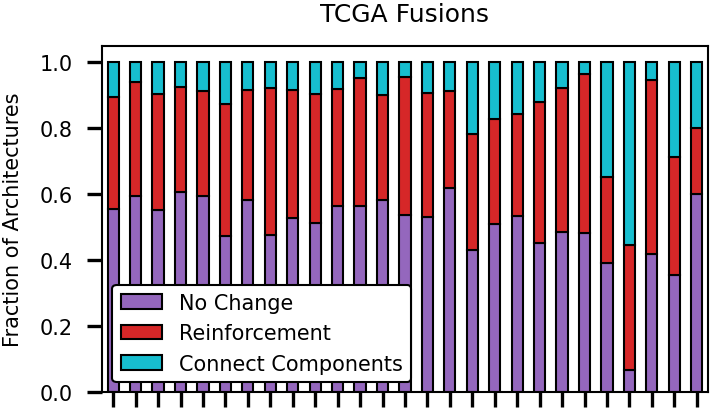

In [ ]:
y = x.drop(['Empty Domain','Total Count'], axis=1).transpose()
y = y/y.sum(axis = 0)
y = y.transpose()
y.plot.bar(stacked=True, edgecolor='k', linewidth = 0.5,color=['tab:purple','tab:red','tab:cyan'])
plt.ylabel('Fraction of Architectures')
l= plt.legend(loc = 'lower left', edgecolor='k',framealpha=1)
l.get_frame().set_linewidth(0.5)
l.get_frame().set_facecolor('w')
plt.title('TCGA Fusions')
fig = plt.gcf()
fig.set_size_inches((2.5,1.5))
fig.set_dpi(300)
ax = plt.gca()
ax.set_xticklabels([])
plt.tight_layout()
plt.savefig('Figures/Manuscript Figures/Figure 3 Fusion Genes/TCGA Network Impact.svg', dpi = 300, transparent=True)

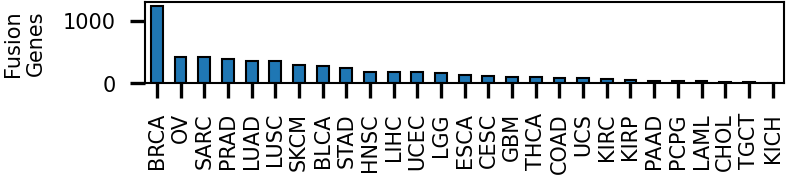

In [24]:
y = x.filter(['Total Count'], axis=1).transpose()
y = y.transpose()
y.plot(kind = 'bar', stacked=True, edgecolor='k', linewidth = 0.5, color = 'tab:blue', legend = False)
plt.ylabel('Fusion\nGenes')
fig = plt.gcf()
fig.set_size_inches((2.75,0.35))
fig.set_dpi(300)
plt.savefig('Figures/Manuscript Figures/Figure 3 Fusion Genes/TCGA Total Fusion Genes Count.png', dpi = 300, transparent=True)

In [25]:
# Loading in the list of pY and pST kinases to allow for annotating patients as having one or the other if they have a kinase
pY_ref = pd.read_csv('Human_tyr-kinase_Only.csv')

In [26]:
# Given that most of the HRs of the fusions shows a very wide CI interval that suggests that this likely too wide of a stratification that by itself is not distinct enough. So as a proof of concept I am checking whether there is kinase domain and if necessary stratifying if it is based on tyrosine or ST
p_cnt = 0
for pt,dets in all_pts.items():
    if 'IPR000719' in dets['Interpro Domain Architecture IDs']:
        py_flag = False
        pst_flag = False
        for gene,gene_dets in dets['Genes'].items():
            # Checking if its contribution is part of the fusion gene or it is just simply a part of it
            if 'IPR000719' in gene_dets['Fusion Protein Contribution IDs']:    
                if gene_dets['UniProt ID'] in pY_ref['UniProt ID'].tolist():
                    py_flag = True
                else:
                    pst_flag = True
        
        if py_flag and pst_flag:
            dets['Kinase'] = 'Both'
        elif py_flag:
            dets['Kinase'] = 'pY'
        elif pst_flag:
            dets['Kinase'] = 'pST'

        p_cnt += 1
    else:
        dets['Kinase'] = 'None'


In [27]:
# Importing the patient clicial information and then checking if their domain architecture was one of those that contributed to changes in the network.
pt_OI_list = set()
for cancer,net_info in fusion_categories.items():
    for net_impact in net_info:
        pt_OI_list = pt_OI_list.union(net_info[net_impact]['Pt Members'])


In [28]:
pt_clinical = pd.read_csv('tcga_clinical_data.tsv', sep = '\t')

In [29]:
# Getting the patient ids from the pts that have network changes
pt_ids = set()
for pt in pt_OI_list:
    pt_ids.add(all_pts[pt]['Pt ID'][:-1])

In [30]:
pt_clinical_filt = pt_clinical.copy()
pt_clinical_filt.drop_duplicates(subset='Sample ID',inplace=True, keep='first')
pt_clinical_filt.index = pt_clinical_filt['Sample ID']



In [31]:
# Grabbing only columns of interest for downstream analysis.
cols_2_keep = ['Patient ID','Sample ID','Diagnosis Age','Cancer Type','TCGA PanCanAtlas Cancer Type Acronym','Disease Free (Months)','Disease Free Status','Months of disease-specific survival','Disease-specific Survival status','Overall Survival (Months)','Overall Survival Status']

In [32]:
pt_clinical_filt = pt_clinical_filt.filter(pt_ids, axis = 0).filter(cols_2_keep, axis=1)

In [33]:
pt_nofus_filt = pt_clinical.copy()
pt_nofus_filt.drop_duplicates(subset = 'Sample ID', inplace=True, keep='first')
pt_nofus_filt.index = pt_nofus_filt['Sample ID']
dbl_check_pts = set(pt_ids).intersection(pt_nofus_filt.index)
pt_nofus_filt= pt_nofus_filt.drop(dbl_check_pts,axis=0).filter(cols_2_keep, axis=1)

In [34]:
# Creating a TCGA sample id to patient id conversion dict
tcga_id_conv = {v['Pt ID']:k for k,v in all_pts.items() if k in pt_OI_list}


In [35]:
# Checking to see how many patients have multiple fusions
multi_fus = {}
for fus,dets in all_pts.items():
    pt_id = dets['Pt ID']
    if tcga_id_conv[pt_id] != fus:
        if pt_id not in multi_fus:
            multi_fus[pt_id] = []
        multi_fus[pt_id].append(fus)

for pt in multi_fus:
    multi_fus[pt].append(tcga_id_conv[pt])

In [36]:
# Removing patients for the time being from those within the tcga conversion
for pt in multi_fus.keys():
    del tcga_id_conv[pt]

In [37]:
network_change_cats = {'Interconnectedness':'Reinforcement',
                       'Connect Components':'Connect Components',
                       'No Change':'No Change',
                       'Empty Domain':'Unannotated Domains'}

In [38]:
pt_nofus_filt['Network Change'] = 'No Fusion'


In [39]:
# Getting each patient's impact on the network and appending it onto the clinical dataframe
cnt = 0
skpped_ids = set()
pt2kp = set()
for pt,row in pt_clinical_filt.iterrows():
    can = row['TCGA PanCanAtlas Cancer Type Acronym']
    pt_id = pt+'A'
    chck_dets = True
    
    # Note this is very inefficient and will absolutely need to change this is just to get the data quickly
    fusionOI = fusion_categories[can]
    if pt_id in tcga_id_conv.keys():
        ptOI = tcga_id_conv[pt_id]
    elif pt_id in multi_fus.keys():
        pt_clinical_filt.loc[pt, 'Network Change'] = 'Multiple Fusions'
        av = 0
        py_flag = False
        pst_flag = False
        for fus_sub in multi_fus[pt_id]:
            if all_pts[fus_sub]['Interpro Domain Architecture IDs'] != '':
                av += len(all_pts[fus_sub]['Interpro Domain Architecture IDs'].split('|'))

                # Finding out if a kinase domain is present:
                if 'IPR000719' in all_pts[fus_sub]['Interpro Domain Architecture IDs']:
                    
                    for gene,gene_dets in all_pts[fus_sub]['Genes'].items():
                        # Checking if its contribution is part of the fusion gene or it is just simply a part of it
                        if 'IPR000719' in gene_dets['Fusion Protein Contribution IDs']:    
                            if gene_dets['UniProt ID'] in pY_ref['UniProt ID'].tolist():
                                py_flag = True
                            else:
                                pst_flag = True
           
        if py_flag and pst_flag:
            pt_clinical_filt.loc[pt,'Kinase'] = 'Both'
        elif py_flag:
            pt_clinical_filt.loc[pt,'Kinase'] = 'pY'
        elif pst_flag:
            pt_clinical_filt.loc[pt,'Kinase'] = 'pST'
        else:         
            pt_clinical_filt.loc[pt,'Kinase'] = 'None'
        av = av/len(multi_fus[pt_id])
        chck_dets = False
        pt_clinical_filt.loc[pt,'Fusion Architecture Length'] = av
    # Checking a second version which is whether it ends with B instead
    pt_id = pt + 'B'
    if pt_id in tcga_id_conv.keys():
        ptOI = tcga_id_conv[pt_id]
    elif pt_id in multi_fus.keys():
        av = 0
        for fus_sub in multi_fus[pt_id]:
            if all_pts[fus_sub]['Interpro Domain Architecture IDs'] != '':
                av += len(all_pts[fus_sub]['Interpro Domain Architecture IDs'].split('|'))
                # Finding out if a kinase domain is present:
                if 'IPR000719' in all_pts[fus_sub]['Interpro Domain Architecture IDs']:
                    
                    for gene,gene_dets in all_pts[fus_sub]['Genes'].items():
                        # Checking if its contribution is part of the fusion gene or it is just simply a part of it
                        if 'IPR000719' in gene_dets['Fusion Protein Contribution IDs']:    
                            if gene_dets['UniProt ID'] in pY_ref['UniProt ID'].tolist():
                                py_flag = True
                            else:
                                pst_flag = True
           
        if py_flag and pst_flag:
            pt_clinical_filt.loc[pt,'Kinase'] = 'Both'
        elif py_flag:
            pt_clinical_filt.loc[pt,'Kinase'] = 'pY'
        elif pst_flag:
            pt_clinical_filt.loc[pt,'Kinase'] = 'pST'
        else:         
            pt_clinical_filt.loc[pt,'Kinase'] = 'None'
        av = av/len(multi_fus[pt_id])
        pt_clinical_filt.loc[pt, 'Network Change'] = 'Multiple Fusions'
   
        chck_dets = False
        pt_clinical_filt.loc[pt,'Fusion Architecture Length'] = av
    else:
        cnt += 1
        skpped_ids.add(pt)
    
    if chck_dets:
        for k,net_dets in fusionOI.items():
            if ptOI in net_dets['Pt Members']:
                pt_netchange = k

        pt_clinical_filt.loc[pt, 'Network Change'] = network_change_cats[pt_netchange]
        pt_clinical_filt.loc[pt, 'Kinase'] = all_pts[ptOI]['Kinase']
        if all_pts[ptOI]['Interpro Domain Architecture IDs'] != '':
            pt_clinical_filt.loc[pt,'Fusion Architecture Length'] = len(all_pts[ptOI]['Interpro Domain Architecture IDs'].split('|'))
        else:
            pt_clinical_filt.loc[pt,'Fusion Architecture Length'] = 0



### Getting some summary statistics about the fusion gene domain architectures:
1. Domain architecture length of:
    - Final fusion protein
    - Parental Gene Proteins
2. Changes in the length of donated domains (i.e. are the final fusion proteins simply the joining of two proteins or actual swapping of domains)
3. 

In [40]:
def trueLength(ngram):
    if ngram == '':
        tl = 0
    else:
        tl = len(ngram.split('|'))

    return tl


In [41]:
fusion_arch_lens = []
fusion_archs = {}
five_contrib = {}
five_arch_len = []
three_arch_len = []
three_contrib = {}
dArchLen = []
five_contrib_len = []
three_contrib_len = []
kin_nums = 0
for pt,pt_info in all_pts.items():
    
    arch = pt_info['Interpro Domain Architecture IDs']
    
    # Getting counts for each fusion protein's domain architecture
    if arch in fusion_archs:
        fusion_archs[arch] += 1
    else:
        fusion_archs[arch] = 1
    
    # Flag for fusion domain architecture being novel to designate how often a donated n-gram contributes to novel architectures
    novel_flag = arch not in nat_ngrams_ids
    if novel_flag and 'IPR000719' in arch:
        kin_nums += 1
    # Architecture length
    fusion_arch_lens.append(trueLength(arch))

    # Architecture length of the fusion parents
    for _,gene in pt_info['Genes'].items():
        if 'Interpro Domain Architecture' in gene.keys():
            gene_arch = gene['Interpro Domain Architecture IDs']
            gal = trueLength(gene_arch)
            gene_contrib = gene['Fusion Protein Contribution IDs']
            cal = trueLength(gene_contrib)
            dArchLen.append(gal-cal)
            if gene['Fusion pos'] == 5:
                five_arch_len.append(gal)
                five_contrib_len.append(cal)
                if gene_contrib in five_contrib:
                    five_contrib[gene_contrib]['Count'] += 1
                else:
                    five_contrib[gene_contrib] = {'Count':1, 'Novelty_Count':0}
                
                if novel_flag:
                    five_contrib[gene_contrib]['Novelty_Count'] += 1
            
            else:
                three_arch_len.append(gal)
                three_contrib_len.append(cal)
                if gene_contrib in three_contrib:
                    three_contrib[gene_contrib]['Count'] += 1
                else:
                    three_contrib[gene_contrib] = {'Count':1, 'Novelty_Count':0}
                
                if novel_flag:
                    three_contrib[gene_contrib]['Novelty_Count'] += 1

        else:
            
            if gene['Fusion pos'] == 5:
                five_arch_len.append(0)
            else:
                three_arch_len.append(0)

In [42]:
kin_nums

85

In [43]:
# Ranking the domain architectures derived from the parent genes to determine which ones are the most frequently donated architecture. This will exclude the unannotated/unstructured donations.

thr_rnk = pd.DataFrame.from_dict(three_contrib, orient='index')
fv_rnk = pd.DataFrame.from_dict(five_contrib, orient='index')

thr_rnk.drop('', axis = 0, inplace=True)
fv_rnk.drop('', axis=0, inplace=True)
thr_rnk['C-rank']=thr_rnk['Count'].rank(axis=0, ascending=False, method='min')
fv_rnk['N-rank']=fv_rnk['Count'].rank(axis=0, ascending=False, method='min')

In [46]:
comp_rnk = fv_rnk.join(thr_rnk,lsuffix='_N', rsuffix='_C',how='outer')
comp_rnk['Count_C'].fillna(0, inplace=True)
comp_rnk['Count_N'].fillna(0, inplace=True)
comp_rnk['Novelty_Count_C'].fillna(0, inplace=True)
comp_rnk['Novelty_Count_N'].fillna(0, inplace=True)
comp_rnk['N-rank'].fillna(len(comp_rnk), inplace=True)
comp_rnk['C-rank'].fillna(len(comp_rnk), inplace=True)
comp_rnk['Total Contributions'] = comp_rnk['Count_N'] + comp_rnk['Count_C']
comp_rnk['N Fraction'] = comp_rnk['Count_N']/comp_rnk['Total Contributions']
comp_rnk['C Fraction'] = comp_rnk['Count_C']/comp_rnk['Total Contributions']
comp_rnk['N F-rank'] = comp_rnk['N Fraction'].rank(axis = 0, ascending=False, method = 'min')
comp_rnk['C F-rank'] = comp_rnk['C Fraction'].rank(axis = 0, ascending=False, method = 'min')
comp_rnk['T-rank'] = comp_rnk['Total Contributions'].rank(axis = 0, ascending=False, method = 'min')
comp_rnk['Total Novelty'] = comp_rnk['Novelty_Count_C'] + comp_rnk['Novelty_Count_N']
comp_rnk['Novelty Fraction'] = (comp_rnk['Novelty_Count_C'] + comp_rnk['Novelty_Count_N'])/comp_rnk['Total Contributions']
comp_rnk['N Novelty Rank'] = comp_rnk['Novelty_Count_N'].rank(axis = 0, ascending=False, method='min')
comp_rnk['C Novelty Rank'] = comp_rnk['Novelty_Count_C'].rank(axis = 0, ascending=False, method='min')
comp_rnk['N Novelty Fraction'] = comp_rnk['Novelty_Count_N']/comp_rnk['Count_N']
comp_rnk['C Novelty Fraction'] = comp_rnk['Novelty_Count_C']/comp_rnk['Count_C']
comp_rnk['Novelty Fraction Rank'] = comp_rnk['Novelty Fraction'].rank(axis = 0, ascending=False, method='min')
comp_rnk['Novelty Fraction Rank'] .fillna(len(comp_rnk), inplace=True)
comp_rnk['N Novelty Fraction Rank'] = comp_rnk['N Novelty Fraction'].rank(axis = 0, ascending=False, method='min')
comp_rnk['N Novelty Fraction Rank'].fillna(len(comp_rnk), inplace=True)
comp_rnk['C Novelty Fraction Rank'] = comp_rnk['C Novelty Fraction'].rank(axis = 0, ascending=False, method='min')
comp_rnk['C Novelty Fraction Rank'].fillna(len(comp_rnk), inplace=True)


In [47]:
comp_rnk['Average Rank'] = comp_rnk[['C-rank','N-rank', 'N F-rank','C F-rank','T-rank']].mean(axis=1)
comp_rnk['Average Rank Rank'] = comp_rnk['Average Rank'].rank(axis=0, ascending=True, method = 'min')
comp_rnk['Average N Rank'] = comp_rnk[['N-rank', 'N F-rank']].mean(axis=1).rank(axis=0, ascending=True, method = 'min')
comp_rnk['Average C Rank'] = comp_rnk[['C-rank', 'C F-rank']].mean(axis=1).rank(axis=0, ascending=True, method = 'min')
comp_rnk['Average Novelty Rank']=comp_rnk[['N Novelty Fraction Rank', 'C Novelty Fraction Rank','Novelty Fraction Rank']].mean(axis=1).rank(axis=0, ascending=True, method = 'min')
comp_rnk['Novelty Score'] = comp_rnk['Novelty Fraction Rank']*comp_rnk['T-rank']
comp_rnk['Novelty Score Rank'] = comp_rnk['Novelty Score'].rank(axis=0, ascending=True, method = 'min')

In [49]:
plt.figure(figsize=(2.5,1.5),dpi = 300, clear=True)
plt.rcParams['font.size'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlepad'] = 5
titles = ['Five Prime Genes','Three Prime Genes']
colors =['tab:orange','tab:blue']
for i,x in enumerate([five_arch_len, three_arch_len],start=0):
    plt.subplot(1,2,i+1)
    plt.hist(x, bins = range(0,16),density=True, color=colors[i],align='mid',edgecolor='k', linewidth = 0.5)
    plt.title(titles[i], fontdict={'size':5})
    plt.xlabel('Domain Arch. Length')
    if i == 0:
        plt.ylabel('Relative Fraction')
    plt.ylim(0,0.3)
    plt.gca().tick_params(width = 0.5)
plt.tight_layout()
plt.savefig('Figures/Manuscript Figures/Figure 3 Fusion Genes/Donor Gene Architecture Lengths.svg')
plt.close()

In [50]:
plt.figure(figsize=(2.5,1.5),dpi = 300, clear=True)
titles = ['Five Prime Genes','Three Prime Genes']
for i,x in enumerate([five_contrib_len, three_contrib_len],start=0):
    plt.subplot(1,2,i+1)
    plt.hist(x, bins = range(0,16),density=True, color=colors[i],align='mid',edgecolor = 'k', linewidth = 0.5)
    plt.title(titles[i], fontdict={'size':5})
    plt.xlabel('Domain Arch. Length')
    if i == 0:
        plt.ylabel('Relative Fraction')
    plt.ylim(0,0.8)
    plt.gca().tick_params(width = 0.5)
plt.tight_layout()
plt.savefig('Figures/Manuscript Figures/Figure 3 Fusion Genes/Donor Gene Donated Architecture Lengths.svg')
plt.close()

In [51]:
plt.figure(figsize=(1.5,1.5),dpi=300, clear=True)
plt.hist(fusion_arch_lens, bins = range(0,16),density=True, color = 'purple',edgecolor = 'k',linewidth = 0.5)
plt.title('Fusion Protein')
plt.ylabel('Relative Fraction')
plt.xlabel('Domain Arch. Length')
plt.tight_layout()
plt.savefig('Figures/Manuscript Figures/Figure 3 Fusion Genes/Fusion Gene Architecture Lengths.svg',transparent=True)
plt.close()

In [52]:
# Now focusing on the actual domains being donated and lost.

# Will generate a multipartite network to show the final fusions and the frequency of connections that result in them and the two different parent architectures

# Initializing the pandas DataFrame that will contain the adjacency data
comp_fus_stuff = set(five_contrib.keys()).union(three_contrib.keys()).union(fusion_archs.keys())
comp_fus_stuff = list(comp_fus_stuff)
fusion_contrib_df = pd.DataFrame(columns=comp_fus_stuff, index=comp_fus_stuff).fillna(0)
for pt,pt_info in all_pts.items():
    # Getting the fusion and contributing n-grams
    fus = pt_info['Interpro Domain Architecture IDs']
    for _,gene in pt_info['Genes'].items():
        gene_contrib = gene['Fusion Protein Contribution IDs']
        if gene['Fusion pos'] == 5:
            fv = gene_contrib
        else:
            thr = gene_contrib

    for x in [fus, fv, thr]:
        if x not in fusion_contrib_df.columns:
            fusion_contrib_df.assign(x=0)
    
    fusion_contrib_df.loc[fus, fv] += 1
    fusion_contrib_df.loc[fus, thr] += 1

In [53]:
# Removing self-loops
for i in fusion_contrib_df.columns:
    fusion_contrib_df.loc[i,i] = 0

In [54]:
G_fus = nx.from_pandas_adjacency(fusion_contrib_df)
pos_fus = nx.spring_layout(G_fus)


In [55]:
# Trying the multipartite layout by designating the nodes as either the 3', 5' or complete fusion and an intermediate step in between
node_color =[]
node_size = []
multi_comp = []
for node in G_fus.nodes:
    thr_check = node in three_contrib
    fv_check = node in five_contrib
    comp_check = node in fusion_archs
    cnt = 0

    if thr_check and fv_check and comp_check:
        layer = 2
        color = 'red'
        lab = 'All'
        cnt = three_contrib[node]['Count'] + five_contrib[node]['Count'] + fusion_archs[node]
        multi_comp.append(node)
    elif thr_check and comp_check:
        layer = 2
        color = 'darkblue'
        lab = 'ThreeFull'
        cnt = three_contrib[node]['Count'] +fusion_archs[node]
        multi_comp.append(node)
    elif fv_check and comp_check:
        layer = 2
        color = 'darkorange'
        lab = 'FiveFull'
        cnt = five_contrib[node]['Count'] + fusion_archs[node]
        multi_comp.append(node)
    elif thr_check and fv_check:
        layer = 2
        color = 'aquamarine'
        lab = 'ThreeFive'
        cnt = five_contrib[node]['Count'] + three_contrib[node]['Count']
        multi_comp.append(node)
    elif fv_check:
        layer = 1
        color = 'orange'
        lab = 'Five'
        cnt =  five_contrib[node]['Count']
    elif thr_check:
        layer = 3
        color = 'blue'
        lab = 'Three'
        cnt = three_contrib[node]['Count']
    elif comp_check:
        layer = 2
        color = 'purple'
        lab = 'Full'
        cnt =fusion_archs[node]
    
    # For each node I am also adding in a legible name attribute for use downstream
    leg_name = []
    if node != '':
        for x in node.split('|'):
            leg_name.append(interpro_dict[x])
        leg_name = '|'.join(leg_name)
    else:
        leg_name = ''
    node_color.append(color)
    node_size.append(cnt)
    nov = node not in nat_ngrams_ids
    nx.set_node_attributes(G_fus, values={node:{'layer':layer,'color':color,'size':cnt,'Category':lab,'Novel Arch':nov, 'Legible Name':leg_name}})




### From the above network it is clear some of the connected components are single fusion protein components (i.e. the 5', 3' and complete fusion)

To help maximize the information that could be utilized from the full n-grams associated with individual fusions the unique fusion protein connected components will be removed and plotted separately.

In [56]:
G_singles = G_fus.copy()

nodes_2_remove = set()
for cc in nx.connected_components(G_singles):
    if len(cc) > 3:
        nodes_2_remove = nodes_2_remove.union(cc)

G_singles.remove_nodes_from(list(nodes_2_remove))
pos_singles = nx.spring_layout(G_singles,k=0.1)

In [57]:
node_color = []
for node in G_singles.nodes(data =True):
    node_color.append(node[1]['color'])

In [59]:
plt.figure(figsize=(1.5,1.5),dpi=300, clear=True)
plt.axis('off')
nx.draw(G_singles, pos_singles, 
        node_color = node_color, 
        width = 0.25, node_size = 1, 
        edgecolors='k', linewidths = 0.1)
cc_num = nx.number_connected_components(G_singles)
plt.title(f'Complete Unique Domain\nFusion Families: {cc_num}',fontdict={'size':5})
plt.tight_layout()
plt.gca().set_aspect(1)
plt.savefig('Figures/Manuscript Figures/Figure 3 Fusion Genes/Domain Fusion Families Network.svg', transparent=True)
plt.close()

### Now focusing only n-grams that are spread across mutliple fusions

In [64]:
G_multi = G_fus.copy()
G_multi.remove_nodes_from(G_singles.nodes)
multi_pos = nx.spring_layout(G_multi, k =0.04)


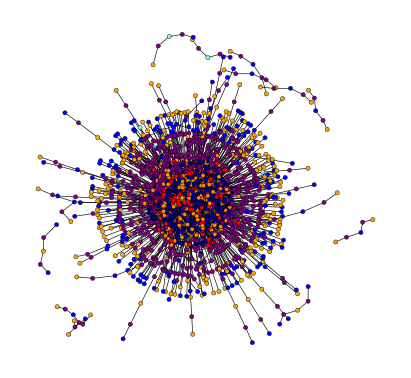

In [66]:
plt.figure(figsize=(1.5,1.5),dpi=300, clear=True)
plt.axis('off')
node_color = []
for node in G_multi.nodes(data = True):
    node_color.append(node[1]['color'])
nx.draw(G_multi, multi_pos, 
        node_color = node_color, 
        width = 0.15, node_size = 1, 
        edgecolors='k', linewidths = 0.1)
plt.tight_layout()
plt.gca().set_aspect(1)
plt.savefig('Figures/Manuscript Figures/Figure 3 Fusion Genes/Multi Fusion Domain Families.svg', transparent=True)

In [67]:
# Becasue there are nodes that are associated with multiple components of the fusion protein now there is a need to differentiate them partially in the network and in a potential Sankey plot. To do this going back one step that grabs and designates whether an n-gram is part of the 5', 3' or complete fusion.

# Fortunately we can speed up some of this process by cross-checking with the previously determined sets.
fus_ngram_chck = set()

# Combining the sets together into a single one for checking
for node in G_multi.nodes(data=True):
    if node[1]['Category'] in ['All','ThreeFull','FiveFull','ThreeFive']:
        fus_ngram_chck.add(node[0])


In [68]:
# This is going through the patients again so will likely need to adjust this code to be somewhat earlier to make it more efficient.

# Dictionary that will be used for creating the final pandas dataframe this will only have the 5' and complete as keys the 3' will only be connected to the complete fusion architecture. In addition to separating them, node attributes like those established above will be generated for these.
fxd_edgelist = {}
fxd_node_attr ={}

suffix = ['_Full','_5','_3']
fus_colors = ['purple','orange','blue']
fus_layers = [2,1,3]

for pt,pt_info in all_pts.items():
    # Getting the fusion and contributing n-grams
    fus = pt_info['Interpro Domain Architecture IDs']
    for _,gene in pt_info['Genes'].items():
        gene_contrib = gene['Fusion Protein Contribution IDs']
        if gene['Fusion pos'] == 5:
            fv = gene_contrib
        else:
            thr = gene_contrib

    # Adjusting the names to account for if they are involved in multiple parts of fusions and adding metadata to the node_attrib dict for network drawing
    adjst_name = []
    for i,x in enumerate([fus, fv, thr]):
        if x in fus_ngram_chck:
            temp = x+suffix[i]
            adjst_name.append(temp)
            if x != '':
                leg = '|'.join([interpro_dict[k] for k in x.split('|')])
            else:
                leg = ''
            if temp not in fxd_node_attr:
                fxd_node_attr[temp] = {'color':fus_colors[i], 
                                       'parent':x,
                                       'layer':fus_layers[i], 
                                       'count':1, 
                                       'category':suffix[i].removeprefix('_'),
                                       'legible':leg}
            else:
                fxd_node_attr[temp]['count'] += 1
        else:
            adjst_name.append(x)
            if x != '':
                leg = '|'.join([interpro_dict[k] for k in x.split('|')])
            else:
                leg = ''
                
            if x not in fxd_node_attr:
                fxd_node_attr[x] ={'color':fus_colors[i], 
                                       'parent':x,
                                       'layer':fus_layers[i], 
                                       'count':1, 
                                       'category':suffix[i].removeprefix('_'),
                                       'legible':leg}
            else:
                fxd_node_attr[x]['count'] += 1

    # Now using the appended names for the new dict
    new_fus = adjst_name[0]
    new_fv = adjst_name[1]
    new_thr = adjst_name[2]

    # Adding the new edge connections
    if new_fus in fxd_edgelist:
        if new_thr not in fxd_edgelist[new_fus]:
            fxd_edgelist[new_fus][new_thr] = 0
        
        fxd_edgelist[new_fus][new_thr] += 1
    else:
        fxd_edgelist[new_fus] = {new_thr:1}
    
    if new_fv in fxd_edgelist:
        if new_fus not in fxd_edgelist[new_fv]:
            fxd_edgelist[new_fv][new_fus] = 0
        
        fxd_edgelist[new_fv][new_fus] += 1
    else:
        fxd_edgelist[new_fv] = {new_fus:1}
    

In [69]:
# After generating the complete edge list and node attribtues. Going back and changing the colors associated with the unstructured/unannotated n-grams ('_5', '_3', and '_Full' nodes only) to be a shade of white.

for x in suffix:
    fxd_node_attr[x]['color'] = 'snow'

In [70]:
fxd_adj = pd.DataFrame.from_dict(fxd_edgelist)
fxd_adj['target'] = fxd_adj.index
new_edgelist = fxd_adj.melt(id_vars='target',var_name='source', value_name='weight').dropna()

In [71]:
G_tst = nx.from_pandas_edgelist(new_edgelist,
                                edge_attr=True)
nx.set_node_attributes(G_tst, fxd_node_attr)

# Visualizing n-grams associated with multiple fusions

From the three previous networks there are a few things that can be gleaned.

1. There are certain n-grams spanning all aspects of the fusion protein which will be treated separately from those associated with only specific aspects (either 3' or 5').
2. Certain families of the three aspects are unique (i.e. the 3', 5' and complete fusion n-grams are their own family/connnected component)
3. There are many more fusions generated from multiple 3' and 5' components.

To help with visualizing some of those associated with the 2nd and 3rd point I will be isolating those from the multipartite graph and generating a Sankey plot.

In [73]:
cc_2remove = set()

for cc in nx.connected_components(G_tst):
    if len(cc) < 3:
        cc_2remove = cc_2remove.union(cc)

G_sank = G_tst.copy()
G_sank.remove_nodes_from(list(cc_2remove)) 

sank_source_data = new_edgelist
sank_nodes = list(nx.nodes(G_sank))
sank_mapping_dict = {k:v for v, k in enumerate(sank_nodes)}

In [74]:
# To ensure nodes are oriented where the 5' is on the left and 3' on the right setting an x value based on which component it was associated with also creating a shorthand name in case it needs to be displayed.
labs = []
sank_cols = []
thrcnt = 0
fvcnt = 0
fuscnt = 0
for node in sank_mapping_dict.keys():
    cat = G_sank.nodes[node]['category']
    c = G_sank.nodes[node]['color']
    l = G_sank.nodes[node]['parent']
    p = G_sank.nodes[node]['legible']
    cnt = G_sank.nodes[node]['count']

    # Change color to red if it is a novel domain architecture that does not occur naturally
    if cat =='Full':
        if l not in nat_ngrams_ids:
            c = 'tomato'
    sank_cols.append(c)
    
    if l != None:
        if len(l.split('|')) < 2 and cnt > 3:
            l_short = p
        else:
            l_short = ''
    else:
        l_short = p

    if cat == '3':
        labs.append(l_short)
        
        
    elif cat == '5':
        
        labs.append(l_short)
        
        
    elif cat == 'Full':
        labs.append(l_short)
        
sank_node_attr = {'Colors':sank_cols, 'Mapping Dict':sank_mapping_dict, 'Short_names':labs}

In [75]:
import plotly.graph_objects as go

In [76]:
def generateFocusedSankey(base_ngram, sank_source_data, G_sank, node_attrib):
    '''To generate a Sankey plot focused only on n-grams involving the base n-gram provided as the first argument.
    '''

    # Unpacking a few values
    sank_mapping_dict = node_attrib['Mapping Dict']
    labs = node_attrib['Short_names']
    sank_cols = node_attrib['Colors']

    sank_converted = sank_source_data.copy()
    node_4_analysis = []
    dom_vars = [base_ngram + sufs for sufs in ['_3','_5','_Full']]
    for doms in dom_vars:
        if doms in nx.nodes(G_sank):
            kin_neighs = nx.neighbors(G_sank,doms)
            for node in kin_neighs:
                if base_ngram in node:
                    node_4_analysis.append(node)
    if not node_4_analysis:
        kin_neighs = nx.neighbors(G_sank,base_ngram)
        for node in kin_neighs:
            if base_ngram in node:
                node_4_analysis.append(node)
                
    # Reducing the Sankey data to that of interest
    sank_converted.loc[~((sank_converted['target'].isin(node_4_analysis) )|(sank_converted['source'].isin(node_4_analysis))), 'weight']= 0
    snank_data_leg = sank_converted.copy()
    sank_converted['source'] = sank_converted['source'].map(sank_mapping_dict)
    sank_converted['target'] = sank_converted['target'].map(sank_mapping_dict)
    sank_converted = sank_converted.to_dict(orient='list')

    # Getting nodes that are retained in the Sankey diagram
    filt_sank = snank_data_leg[snank_data_leg['weight']>0].copy()
    temp = filt_sank.copy().filter(['source','target']).to_numpy()
    nodes_kept = set()
    for x in temp:
        nodes_kept = nodes_kept.union(x)

    filt_sank['color'] = 'lightgray'

    # Any unstructured/unannotated n-grams are colored whiteish to
    filt_sank.loc[filt_sank['source']=='_5', 'color'] = 'snow'
    filt_sank.loc[filt_sank['target']=='_3', 'color'] = 'snow'

    # The base n-gram of interest is highlighted
    filt_sank.loc[filt_sank['source'] == base_ngram, 'color'] = 'goldenrod'
    filt_sank.loc[filt_sank['source'] == base_ngram+'_5', 'color'] = 'goldenrod'
    filt_sank.loc[filt_sank['target'] == base_ngram, 'color'] = 'lightblue'
    filt_sank.loc[filt_sank['target'] == base_ngram+'_3', 'color'] = 'lightblue'
    filt_sank_conv = filt_sank.copy()
    filt_sank_conv['target'] = filt_sank_conv['target'].map(sank_mapping_dict)
    filt_sank_conv['source'] = filt_sank_conv['source'].map(sank_mapping_dict)

    # Defining the Sankey plot
    sankey_dig = go.Sankey(
        node=dict(pad = 100,
                thickness = 10,
                line = dict(color = "black", width = 0.5),
                color = sank_cols,
                label = labs,
                customdata = [k for k in sank_mapping_dict.keys()],
                hovertemplate = 'Node %{customdata}',
                ),
        link = dict(
            source = filt_sank_conv['source'],
            target = filt_sank_conv['target'],
            value = filt_sank_conv['weight'],
            color = filt_sank['color'],
            line = dict(
                color = 'black',
                width = 0.25
            ),
            hovertemplate = 'Link from %{source.customdata}<br /> to %{target.customdata}<br /> with %{value}'

        ))

    fig = go.Figure(data=sankey_dig)
    fig.update_layout(height = 500, width = 400,
                    margin = dict(
                        l = 10,
                        r = 10,
                        t = 10,
                        b = 10
                    ))
    
    return fig


### Prior to visualizing adding in some analysis associated with the natural diversity of domain architecture partners individual domains have to determine if the top domains that are transferred are expected to in some shape or form.

In [77]:
# Importing the domain diversity indices.

dom_div = pd.read_json('10-gram Simpson Diversity Index.json')


In [78]:
# Now getting the full distribution of diversity indices for the domain n-grams found within fusions
base_filt_div = dom_div.filter(comp_rnk.index, axis=0)

In [79]:
import scipy.stats as stats

In [80]:
import random

In [81]:
pvals = []
for i in range(1000):
    tst_dist = random.sample(dom_div['Prospective'].tolist(), k=len(base_filt_div))
    res = stats.mannwhitneyu(tst_dist,dom_div['Prospective'],nan_policy='omit')
    pvals.append(res.pvalue)

In [82]:
stats.mannwhitneyu(base_filt_div['Prospective'],dom_div['Prospective'],nan_policy='omit')

MannwhitneyuResult(statistic=8820210.0, pvalue=5.975000524502265e-17)

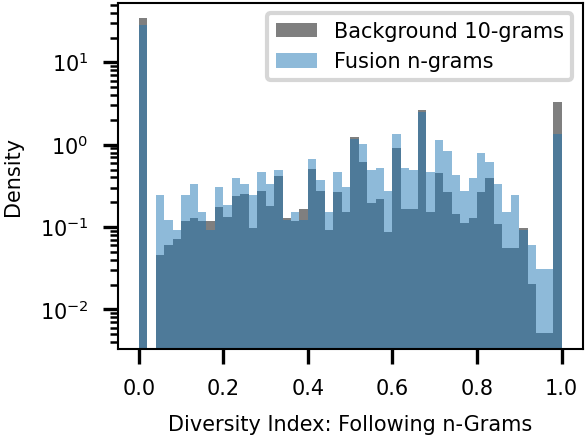

In [83]:
# Now generating histograms for both diversity indices to show how they look compared to the baseline whole proteome one
plt.figure(figsize=(2,1.5),dpi=300)
dom_div['Prospective'].plot.hist(bins=50,density=True,color='tab:gray',label='Background 10-grams')
base_filt_div['Prospective'].plot.hist(bins=50,density=True,alpha=0.5,color='tab:blue',label='Fusion n-grams')
plt.ylabel('Density')
plt.xlabel('Diversity Index: Following n-Grams')
plt.legend()
plt.yscale('log')
plt.savefig('Figures/Manuscript Figures/Supplementary Figure Fusion Domain Broad Networks Characterization/All fusions following diversity.svg')

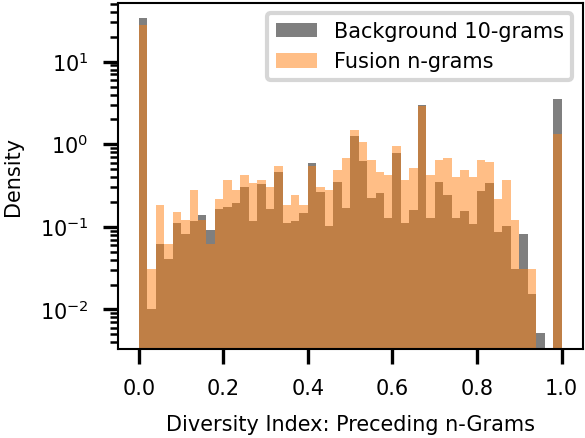

In [84]:
plt.figure(figsize=(2,1.5),dpi=300)
dom_div['Retrospective'].plot.hist(bins=50,density=True,color='tab:gray',label='Background 10-grams')
base_filt_div['Retrospective'].plot.hist(bins=50,density=True,alpha=0.5,color='tab:orange',label='Fusion n-grams')
plt.ylabel('Density')
plt.xlabel('Diversity Index: Preceding n-Grams')
plt.yscale('log')
plt.legend()
plt.savefig('Figures/Manuscript Figures/Supplementary Figure Fusion Domain Broad Networks Characterization/All fusions preceding diversity.svg')

In [85]:
top_rnking = comp_rnk.sort_values(['T-rank','Total Novelty'])
top_rnking = top_rnking.filter(top_rnking.index[0:100],axis=0).filter(['Total Contributions','Total Novelty','Novelty Fraction'], axis=1)


In [86]:
top_rnking= top_rnking.merge(base_filt_div, left_index=True, right_index=True)

In [87]:
# Now retrieving the some of the network values to relate fusion count to connections it makes
dc_full = nx.degree_centrality(G)
bc_full = nx.betweenness_centrality(G)

In [88]:
# Combining the centralities into a single dataframe and then merging with the diversity index dataframe
dc_df = pd.DataFrame.from_dict(dc_full,orient='index',columns=['Degree'])
bc_df = pd.DataFrame.from_dict(bc_full,orient='index',columns=['Betweenness'])
cents_df = dc_df.merge(bc_df, left_index=True, right_index=True)
top_rnking = top_rnking.merge(cents_df, left_index=True, right_index=True)

In [89]:
ets_pt_num = 0
ets_pts = []
for pt,pt_info in all_pts.items():
    if 'IPR003118|IPR000418' in pt_info['Interpro Domain Architecture IDs']:
        ets_pt_num += 1
        ets_pts.append(pt)


In [90]:
ets_impact = {}
for imp,imp_dets in fusion_categories['PRAD'].items():
    ets_impact[imp] = 0
    cm_pts = set(imp_dets['Pt Members']).intersection(ets_pts)
    ets_impact[imp] = len(cm_pts)

In [91]:
ets_impact

{'No Change': 30,
 'Interconnectedness': 0,
 'Connect Components': 0,
 'Empty Domain': 0}

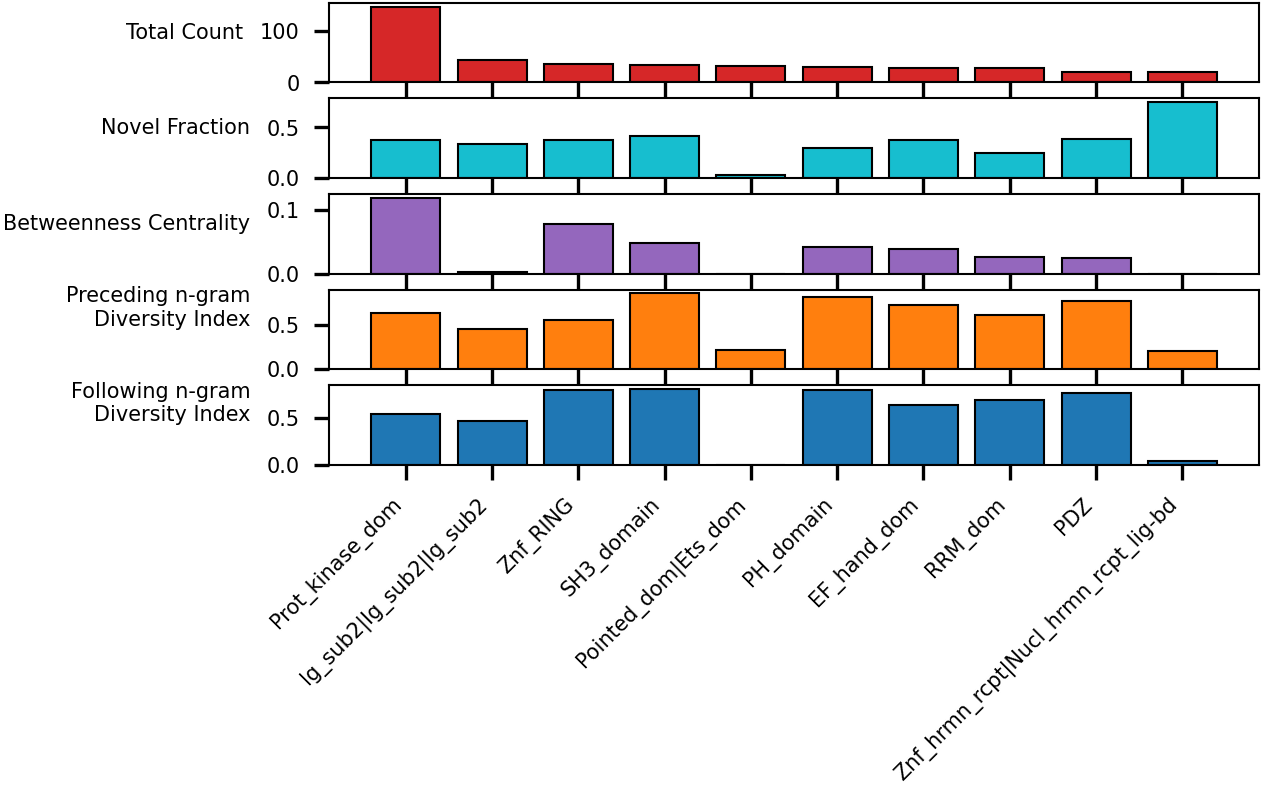

In [92]:
# Only focusing on the top 10 domain n-grams that had the most fusions
n = 9
ngram_labs=[]
for i in top_rnking.index[0:n+1]:
    i_str = '|'.join([interpro_dict[k] for k in i.split('|')])
    ngram_labs.append(i_str)

plt.figure(figsize=(4,2),dpi=300)
plt.subplot(5,1,1)
plt.bar(top_rnking.index[0:n+1],top_rnking['Total Contributions'][0:n+1],color='tab:red',linewidth=0.5,edgecolor='k')
ax = plt.gca()
ax.set_xticklabels([])
plt.ylabel('Total Count',rotation=0, horizontalalignment='right')
plt.subplot(5,1,2)
plt.bar(top_rnking.index[0:n+1],top_rnking['Novelty Fraction'][0:n+1],color='tab:cyan',linewidth=0.5,edgecolor='k')
ax = plt.gca()
ax.set_xticklabels([])
plt.ylabel('Novel Fraction',rotation=0, horizontalalignment='right')
plt.subplot(5,1,3)
plt.bar(top_rnking.index[0:n+1],top_rnking['Betweenness'][0:n+1],color='tab:purple',linewidth=0.5,edgecolor='k')
ax = plt.gca()
ax.set_xticklabels([])
plt.ylabel('Betweenness Centrality',rotation=0, horizontalalignment='right')
plt.subplot(5,1,4)
plt.bar(top_rnking.index[0:n+1],top_rnking['Retrospective'][0:n+1],color='tab:orange',linewidth=0.5,edgecolor='k')
ax = plt.gca()
ax.set_xticklabels([])
plt.ylabel('Preceding n-gram\nDiversity Index',rotation=0, horizontalalignment='right')
plt.subplot(5,1,5)
plt.bar(top_rnking.index[0:n+1],top_rnking['Prospective'][0:n+1],color='tab:blue',linewidth=0.5,edgecolor='k')
ax = plt.gca()
ax.set_xticks(top_rnking.index[0:n+1],labels=ngram_labs, rotation= 45, horizontalalignment='right')
plt.ylabel('Following n-gram\nDiversity Index',rotation=0, horizontalalignment='right')
plt.savefig('Figures/Manuscript Figures/Supplementary Figure Fusion Domain Broad Networks Characterization/Top Fusions Domain n-gram Measurements.svg')

In [ ]:
# Using the above function and generating Sankey Plots for the top 5 n-grams used in fusions.
ngram_OI = ['IPR000719','IPR001523','IPR001909','IPR001356','IPR013087','IPR017452']
import kaleido
import plotly

for ngram in ngram_OI:
    leg_name=interpro_dict[ngram]
    f = generateFocusedSankey(ngram, sank_source_data, G_sank=G_sank, node_attrib=sank_node_attr)
    height = 150
    width = 100
    f.update_layout(font_size=6.5,height = height, width=width, font_color ='black', font_family = 'arial')
    
    #f.write_image(f'Figures/Manuscript Figures/Figure 3 Fusion Genes/{leg_name} Sankey Plot.svg', scale=1, engine='kaleido')
    f.show()
    

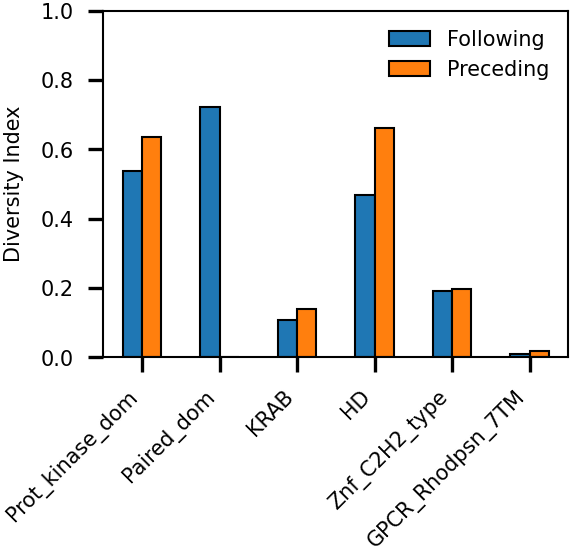

In [94]:
div_OI = dom_div.filter(ngram_OI, axis=0).rename(columns={'Prospective':'Following','Retrospective':'Preceding'})
ng_names = [interpro_dict[k] for k in ngram_OI]

div_OI.plot.bar(edgecolor='k',linewidth=0.5)
ax = plt.gca()
ax.set_xticks(ax.get_xticks(), labels=ng_names,rotation = 45, horizontalalignment = 'right')
plt.gcf().set_dpi(300)
plt.gcf().set_size_inches(2,1.5)
plt.ylabel('Diversity Index')
plt.ylim(0,1)
plt.legend(frameon=False)
plt.savefig('Figures/Manuscript Figures/Supplementary Figure Fusion Domain Broad Networks Characterization/Diversity Index Select Domains.svg')

In [95]:
# Plotting the number of fusions relative to the centrality measures and the size of each dot relative to the fraction of novel architectures.
comb_data = comp_rnk.filter(['Total Contributions','Total Novelty','Novelty Fraction'], axis=1).merge(cents_df, left_index=True, right_index=True)

# Also setting the colors so that n-grams which contain kinases are in one color
comb_data['Kinase'] = comb_data.index.to_series().apply(lambda x: 'tab:red' if 'IPR000719' in x else 'tab:gray')

In [96]:
# To make sure marker sizes are reasonable
x = max(comb_data['Total Contributions'])
mrk_sz = {i:k for i,k in enumerate(np.linspace(start=0,stop=50,num=int(x+1)))}
comb_data['Count'] = comb_data['Total Contributions'].apply(lambda x: mrk_sz[x])

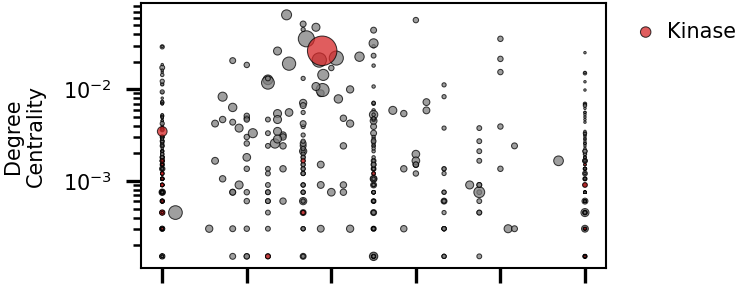

In [97]:
f = comb_data[comb_data['Kinase'] == 'tab:gray'].plot.scatter(s = 'Count', y ='Degree', x='Novelty Fraction',c = 'Kinase',alpha=0.75, edgecolor='k',linewidth=0.25)
comb_data[comb_data['Kinase'] != 'tab:gray'].plot.scatter(s = 'Count', y ='Degree', x='Novelty Fraction',c = 'Kinase',alpha=0.75, edgecolor='k',linewidth=0.25,ax=f,label = 'Kinase')
f.set_yscale('log')
f.legend(markerscale=0.5,bbox_to_anchor = [1,1],frameon=False, handletextpad=0.01)
f.set(xlabel=None)
f.set_xticklabels([])
plt.ylabel('Degree\nCentrality')
plt.gcf().set_dpi(300)
plt.gcf().set_size_inches(2,1.15)
plt.savefig('Figures/Manuscript Figures/Figure 3 Fusion Genes/All Fusions Degree Centrality Novelty Scatter.svg')

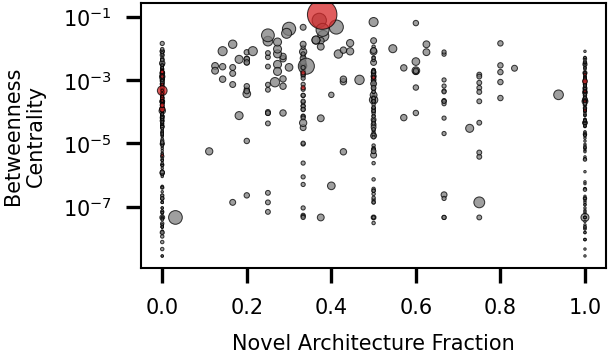

In [98]:
f = comb_data[comb_data['Kinase'] == 'tab:gray'].plot.scatter(s = 'Count', y ='Betweenness', x='Novelty Fraction',c = 'Kinase',alpha=0.75, edgecolor='k',linewidth=0.25)
comb_data[comb_data['Kinase'] != 'tab:gray'].plot.scatter(s = 'Count', y ='Betweenness', x='Novelty Fraction',c = 'Kinase',alpha=0.75, edgecolor='k',linewidth=0.25,ax=f)

ax = plt.gca()
#ax.set_xscale('log')
ax.set_yscale('log')
plt.gcf().set_dpi(300)
plt.gcf().set_size_inches(2,1.15)
plt.xlabel('Novel Architecture Fraction')
plt.ylabel('Betweenness\nCentrality')
plt.savefig('Figures/Manuscript Figures/Figure 3 Fusion Genes/All Fusions Betweenness Centrality Novelty Scatter.svg')

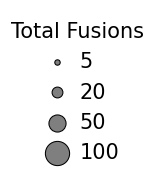

In [99]:
# Creating a fucking legend that works
f = plt.figure(figsize=(0.5,0.5),dpi=300)
ax=plt.gca()

x = max(comb_data['Total Contributions'])

mrk_legend = {i:k for i,k in mrk_sz.items() if i in [5,20,50,100]}
h,labs = [],[]
for s in mrk_legend.keys():
    h.append(ax.scatter([],[],mrk_legend[s],color='tab:gray',edgecolors='k',linewidths=0.25))
    labs.append(f'{s}')
ax.legend(h,labs,title='Total Fusions',frameon=False,handletextpad=0.1)
ax.set_axis_off()
plt.savefig('Figures/Manuscript Figures/Figure 3 Fusion Genes/Size Legend.svg')

### Given the prevalence of kinases being involved in kinases I am now splitting them up into the pY v pST kinases

In [100]:
# Importing the pY kinases and then going through each of the kinase patients and splitting them
pY_ref = pd.read_csv('Human_tyr-kinase_Only.csv')

In [101]:
kin_pts = {}
kin_prots = {'Novel':set(),'Preexisting':set()}
krab_prots = {'Novel':set(),'Preexisting':set()}
for pt, pt_info in all_pts.items():
    arch = pt_info['Interpro Domain Architecture IDs']
    if 'IPR000719' in arch:
        kin_pts[pt] = pt_info.copy()
        uniprot_ids = set()
        for ensembl, gene_info in pt_info['Genes'].items():
            rowOI = gene_ID_conv_clean[gene_ID_conv_clean['Gene stable ID'] == ensembl] #They should all be the same
            if 'IPR000719' in gene_info['Fusion Protein Contribution IDs']:
                uniprot_ids.update(rowOI['UniProtKB/Swiss-Prot ID'].tolist())
        
        if set(uniprot_ids).intersection(pY_ref['UniProt ID'].tolist()) != set():
            kin_pts[pt]['Kinase Type'] = 'pY'
        else:
            kin_pts[pt]['Kinase Type'] = 'pST'
        
        if arch in nat_ngrams_ids:
            kin_pts[pt]['Novel'] = False
            kin_prots['Novel'].update(uniprot_ids)
        else:
            kin_pts[pt]['Novel'] = True
            kin_prots['Preexisting'].update(uniprot_ids)
    
    # Doing something similar for the KRAB domain to get an idea of which ones are contributing to novel domain architectures versus not to do alignment analysis on.
    if 'IPR001909' in arch:
        uniprot_ids = []
        for ensembl, gene_info in pt_info['Genes'].items():
            rowOI = gene_ID_conv_clean[gene_ID_conv_clean['Gene stable ID'] == ensembl] #They should all be the same
            if 'IPR001909' in gene_info['Fusion Protein Contribution IDs']:
                uniprot_ids.append(rowOI['UniProtKB/Swiss-Prot ID'].tolist()[0])
       
        if arch in nat_ngrams_ids:
            krab_prots['Novel'].update(uniprot_ids)
        else:
            krab_prots['Preexisting'].update(uniprot_ids)

In [102]:
# Exporting the proteins to a json file to perform alignment of the domains of interest in a separate script
json_file = 'KRAB Fusion UniProt IDs.json' 
krab_prots['Novel'] = list(krab_prots['Novel'])
krab_prots['Preexisting'] = list(krab_prots['Preexisting'])
with open(json_file,'w') as output:
        json.dump(krab_prots, output)

kin_prots['Novel'] = list(kin_prots['Novel'])
kin_prots['Preexisting'] = list(kin_prots['Preexisting'])
json_file = 'Kinase Fusion UniProt IDs.json' 
with open(json_file,'w') as output:
        json.dump(kin_prots, output)


In [103]:
# Going through the pts with kinase annotations and doing a simple stratification on how often a patient has a novel domain architecture or not.
filt_kin_data = {k:v for k,v in kin_pts.items()}

In [104]:
flds_2_rm = ['Genes','Genome Build','Interpro Domains']
for pt in filt_kin_data:
    for k in flds_2_rm:
        del filt_kin_data[pt][k]

In [105]:
kin_sum = pd.DataFrame(index=['pTyr','pSer/Thr'], columns=['Total','Novel'],data=0)

# Generating a simple bar plot just to start the exploratory process
for pt,pt_info in filt_kin_data.items():
    if pt_info['Kinase Type'] == 'pY':
        kin_sum.loc['pTyr','Total'] += 1
        if pt_info['Novel']:
            
            kin_sum.loc['pTyr','Novel'] += 1
    else:
        kin_sum.loc['pSer/Thr','Total'] += 1
        if pt_info['Novel']:
            kin_sum.loc['pSer/Thr','Novel'] += 1
   

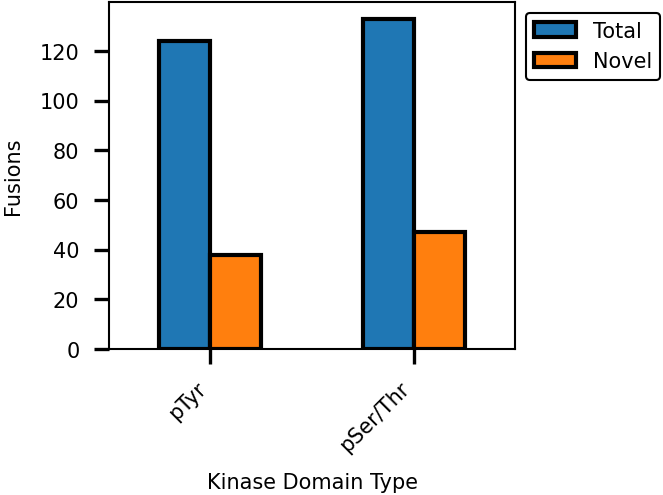

In [106]:
kin_sum.plot.bar(edgecolor ='k')
plt.ylabel('Fusions')
l= plt.legend(edgecolor='k',framealpha=1,bbox_to_anchor =(1.0,1))
l.get_frame().set_linewidth(0.5)
l.get_frame().set_facecolor('w')
fig = plt.gcf()
fig.set_size_inches((1.75,1.5))
fig.set_dpi(300)
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('Kinase Domain Type')
plt.savefig('Figures/Manuscript Figures/Supplemental Figure 6 Kinase Gene Fusions/Fusion Domain Counts.svg')

In [107]:
# Now checking what the domain n-gram network looks like for these ones.

# Gathering all the n-grams from the fusions

kin_fus_ngrams = set()
kin_fus_ngram_dict = {}
kin_fus_ngram_cat = {}
for f,fus_dets in kin_pts.items():
    if 'New N-grams Added' in fus_dets:
        kin_fus_ngrams.update(fus_dets['New N-grams Added'])
    for ngram in fus_dets['N-grams']:
        if ngram not in kin_fus_ngram_dict:
            kin_fus_ngram_dict[ngram] = []
            kin_fus_ngram_cat[ngram] = set()
        kin_fus_ngram_dict[ngram].append(f)
        kin_fus_ngram_cat[ngram].update([fus_dets['Kinase Type']])


In [108]:
# Collapsing the n-grams that are only found in single fusions
kin_fus_ngram_dict_col,_ = ngramUtilities.concatenate_ngrams(kin_fus_ngram_dict,100)
kin_fus_adj = ngramUtilities.return_ngram_adjacency(kin_fus_ngram_dict_col,_,readable=0)
kin_fus_adj.fillna(0,inplace=True)
kin_fus_G = nx.from_pandas_adjacency(kin_fus_adj)
kin_fus_G.remove_edges_from(nx.selfloop_edges(kin_fus_G))

In [109]:
kf_pos = nx.spring_layout(kin_fus_G, k =0.1, seed=882)


In [110]:
# Generating colors for each node based on whether it is associated with pY only or pST or both
node_col_dict = {}
for ngram,cat in kin_fus_ngram_cat.items():
    if cat == set(['pY']):
        node_col_dict[ngram] = 'tab:red'
    elif cat == set(['pST']):
        node_col_dict[ngram] = 'tab:cyan'
    else:
        node_col_dict[ngram] = 'tab:purple'

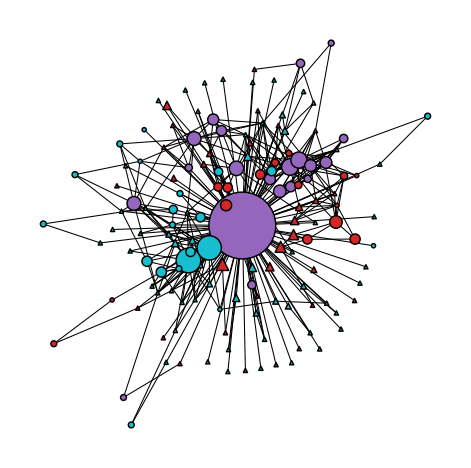

In [111]:
plt.figure(figsize=(2,2), dpi=300)
nx.draw_networkx_edges(kin_fus_G, kf_pos,
        width=0.25)
nx.draw_networkx_nodes(kin_fus_G, kf_pos,nodelist=[n for n in kin_fus_G.nodes() if n in kin_fus_ngrams],
                       node_size=[kin_fus_adj.loc[n,n] for n in kin_fus_G.nodes() if n in kin_fus_ngrams],
                        node_color = [node_col_dict[n] for n in kin_fus_G.nodes() if n in kin_fus_ngrams],
                        node_shape = '^',edgecolors='k',linewidths=0.35)
nx.draw_networkx_nodes(kin_fus_G, kf_pos,nodelist=[n for n in kin_fus_G.nodes() if n not in kin_fus_ngrams],
                       node_size=[kin_fus_adj.loc[n,n] for n in kin_fus_G.nodes() if n not in kin_fus_ngrams],
                        node_color = [node_col_dict[n] for n in kin_fus_G.nodes() if n not in kin_fus_ngrams],
                        node_shape = 'o',edgecolors='k',linewidths=0.35)
plt.box(False)
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure 6 Kinase Gene Fusions/N-gram network.svg')

In [112]:
# Getting the top degree centrality and betweenness centralities.
bc_kf = nx.betweenness_centrality(kin_fus_G)
dc_kf = nx.degree_centrality(kin_fus_G)

In [113]:
kf_cents = pd.DataFrame.from_dict(bc_kf, orient='index',columns=['Betweenness']).merge(pd.DataFrame.from_dict(dc_kf,orient='index',columns=['Degree']),left_index=True,right_index=True)

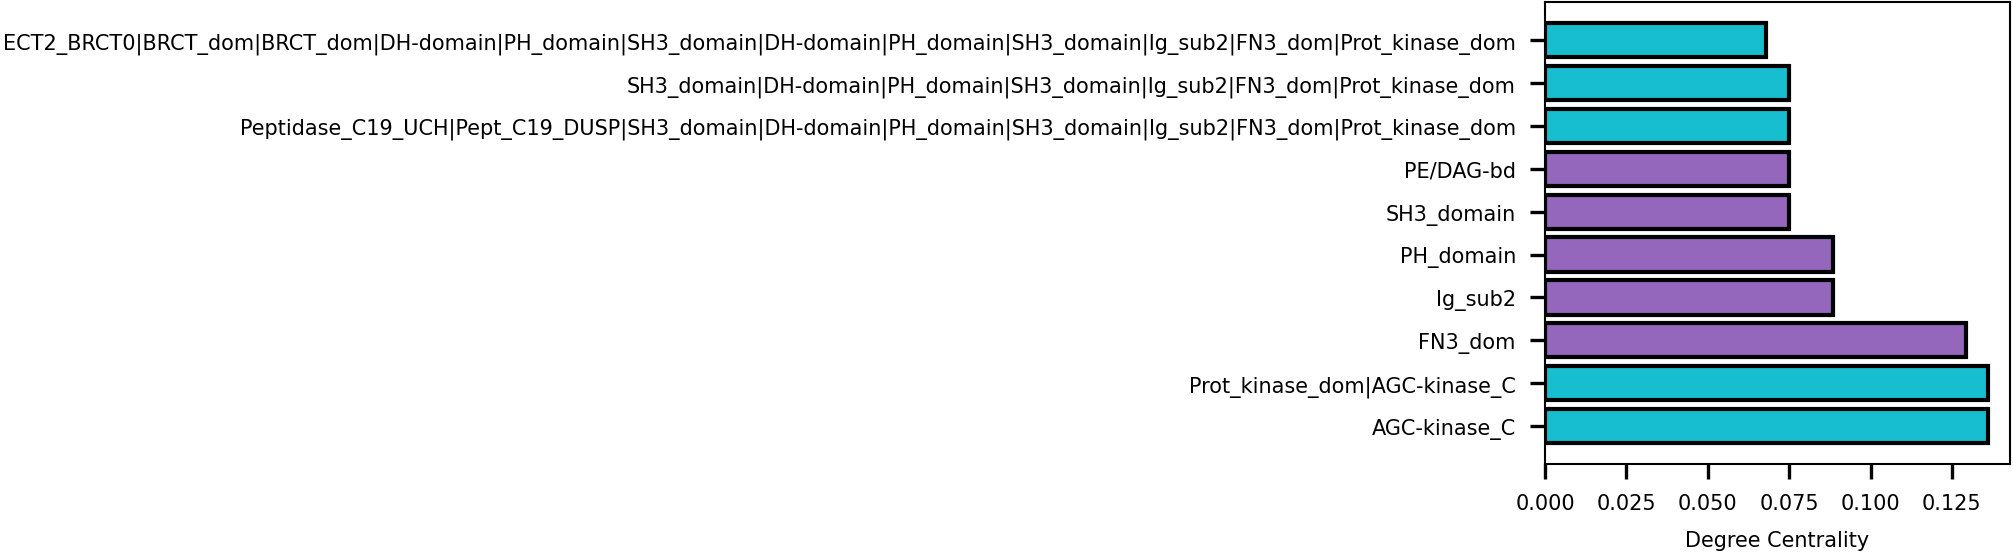

In [114]:
df = kf_cents.drop('IPR000719',axis=0).sort_values('Degree',ascending=False).head(10)

# Converting names for the plot
ngram_names = []
for i in df.index:
    i_list = i.split('|')
    i_list = [interpro_dict[j] for j in i_list]
    ngram_names.append('|'.join(i_list))

plt.barh(ngram_names,df['Degree'],color=[node_col_dict[j] for j in df.index],edgecolor='k')
plt.xticks()
plt.gcf().set_dpi(300)
plt.gcf().set_size_inches(2,2)
plt.xlabel('Degree Centrality')
plt.savefig('Figures/Manuscript Figures/Supplemental Figure 6 Kinase Gene Fusions/Fusion Kinase Ngram Network Degree Centrality.svg')

In [115]:
G_sample = nx.from_edgelist([(0,1),(1,2), (2,3)])
nx.set_node_attributes(G_sample,{n:n for n in G_sample.nodes()},'subset')
pos_sample = nx.multipartite_layout(G_sample)


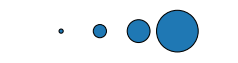

In [116]:
plt.figure(figsize=(1,0.25), dpi=300)
nx.draw_networkx_nodes(G_sample, pos_sample, node_size=[1,10,30,100],edgecolors='k',linewidths=0.25)
plt.box(False)
ax  = plt.gca()
ax.margins(0.5)
plt.savefig('Figures/Manuscript Figures/Supplemental Figure 6 Kinase Gene Fusions/Network Size Key.svg')

In [117]:
# Generating a summary bar graph of the number of nodes that represent novel domain n-grams across the categories.
kin_ngram_bkdn = pd.DataFrame(index=['pTyr','pSer/Thr','Both'],columns=['Novel','Pre-existing']).fillna(0)
col_mapping = {'tab:purple':'Both','tab:cyan':'pSer/Thr','tab:red':'pTyr'}
for n in kin_fus_G.nodes():
    cat = col_mapping[node_col_dict[n]]
    if n in kin_fus_ngrams:
        kin_ngram_bkdn.loc[cat, 'Novel'] += 1
    else:
        kin_ngram_bkdn.loc[cat, 'Pre-existing'] += 1

In [118]:
kin_ngram_bkdn

,Novel,Pre-existing
pTyr,33,15
pSer/Thr,59,21
Both,0,20


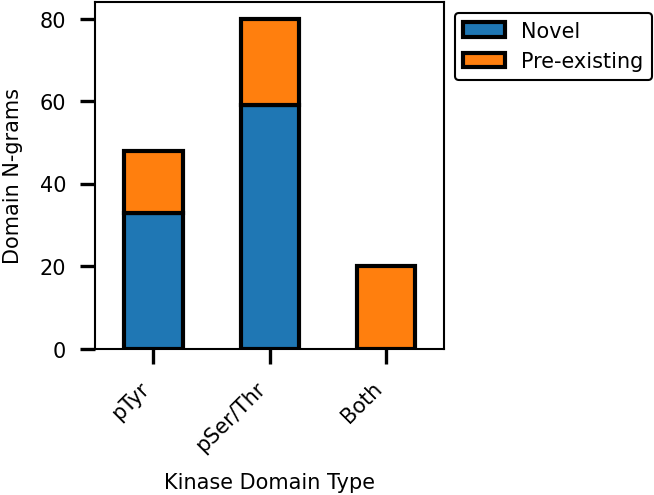

In [119]:
kin_ngram_bkdn.plot.bar(stacked=True,edgecolor='k')
l= plt.legend(edgecolor='k',framealpha=1,bbox_to_anchor =(1.0,1))
l.get_frame().set_linewidth(0.5)
l.get_frame().set_facecolor('w')
plt.gcf().set_size_inches(1.5,1.5)
plt.gcf().set_dpi(300)
plt.ylabel('Domain N-grams')
plt.xlabel('Kinase Domain Type')
plt.xticks(rotation=45, horizontalalignment='right')
plt.savefig('Figures/Manuscript Figures/Supplemental Figure 6 Kinase Gene Fusions/N-gram network nodes novelty.svg')

Generating a null model by taking random domain architectures from the base network and merging them together. 

This will be done about 50-150 times to generate the distributions.

In [13]:
# Extracting recurrent domain architectures

# Defining a helper function that goes through the patient dictionary and get both the patient index, cancer type, and the fusion gene
def find_recurrent_domain_arch(pt_dict):
    '''
    Finds the recurrent domain architectures and returns a dictionary of the patients, fusion genes, and cancer types they occur in.

    Parameters:
    -----------
        - pt_dict: dict
            - dictionary containing the patient information as extracted from the ChimerDB

    Returns:
    --------
        - recur_arch: dict
            - dictionary of each recurrent domain architecture
    '''

    recur_arch = {}

    for pt, dets in pt_dict.items():
        arch = dets['Interpro Domain Architecture IDs'] # Will need to eventually change this to the ID centric one
        fus_gene = dets['Fusion Protein']
        cancer = dets['Cancer Type']
        
        if arch not in recur_arch:
            recur_arch[arch] = {'Patients':[], 'Cancers':set(), 'Fusions':set()}

        recur_arch[arch]['Patients'].append(pt)
        recur_arch[arch]['Cancers'].add(cancer)
        recur_arch[arch]['Fusions'].add(fus_gene)
    

    return recur_arch

In [14]:
full_pts = all_pts
tst = find_recurrent_domain_arch(full_pts)

In [15]:
# Now going through and finding the architectures that are highly recurrent across multiple cancers or have several patients associated with it. Also dropping the empty domain ones.
recur_arch = pd.DataFrame(columns=['Cancers','Fusions','N-gram Length'])
for arch in tst:
    if len(tst[arch]['Cancers']) > 1 and arch != '':
        recur_arch.loc[arch, 'Cancers'] = len(tst[arch]['Cancers'])
        recur_arch.loc[arch, 'Fusions'] = len(tst[arch]['Fusions'])
        recur_arch.loc[arch, 'N-gram Length'] = len(arch.split('|'))

In [16]:
# Getting the domain architectures which are not represented in the collapsed network.
new_archs = set(recur_arch.index.tolist()).difference(proteome_net.adj.columns.tolist())

In [17]:
new_recur_arch = recur_arch.filter(new_archs, axis = 0).sort_values('Cancers', axis=0, ascending=False)
true_nr_arch = new_recur_arch[new_recur_arch['N-gram Length'] > 1]
single_nr_arch = new_recur_arch[new_recur_arch['N-gram Length'] == 1]

In [151]:
true_nr_arch

,Cancers,Fusions,N-gram Length
IPR003598|IPR003598|IPR003598|IPR007707,8,3,4
IPR040665|IPR000719,5,5,2
IPR000494|IPR006211|IPR000494|IPR001452,5,1,4
IPR003118|IPR000719,4,1,2
IPR032101|IPR016137,4,4,2
...,...,...,...
IPR003598|IPR003598|IPR003598|IPR003598|IPR003961|IPR003961|IPR003961|IPR003961|IPR003961|IPR003961|IPR003961|IPR003961|IPR003961|IPR003961|IPR003961|IPR003961|IPR003961,2,2,17
IPR035624|IPR000719,2,1,2
IPR000602|IPR015341|IPR048534,2,2,3
IPR013724|IPR013724|IPR032352|IPR022018,2,2,4


In [152]:
max_can = 2 # Recurrent fusions should be happening in 2 or more cancers
top_cand = true_nr_arch[true_nr_arch['Cancers'] >= max_can].index.tolist()
top_cand.extend(single_nr_arch.index[0:10].tolist()) 
rep_pt = [v['Patients'][0] for k,v in tst.items() if k in top_cand]
rep_pt_data = {k:v for k,v in full_pts.items() if k in rep_pt}

In [153]:
import fusionGeneAnalysis

In [154]:
top_recur_topo = fusionGeneAnalysis.calc_fusion_network_changes(rep_pt_data,proteome_net.adj,proteome_net.collapsed_ngrams,proteome_gross_topo)

100%|██████████| 79/79 [01:02<00:00,  1.25it/s]

There were 0 architecture(s) skipped due to presence in the original adjacency matrix.


In [155]:
top_recur_topo

,Connected Components,Isolates,Articulation Points,New N-gram Count,Reintroduced N-grams,New Nodes,New Edges
89457,0,0,0,0,1,1,4
89570,0,0,0,0,1,1,3
89575,0,1,0,0,1,1,1
89935,0,0,0,0,1,1,3
98123,0,0,0,3,2,3,20
...,...,...,...,...,...,...,...
88876,0,0,0,0,1,1,3
89212,0,0,0,0,1,1,38
81559,0,0,0,0,1,1,4
104518,0,0,0,0,1,1,6


In [156]:
for pt in top_recur_topo.index:
    top_recur_topo.loc[pt,'Domain Architecture'] = rep_pt_data[pt]['Interpro Domain Architecture']

In [157]:
rep_pt = [v['Patients'][0] for k,v in tst.items() if k in new_archs]
rep_pt_data = {k:v for k,v in full_pts.items() if k in rep_pt}

In [158]:
recur_topo= fusionGeneAnalysis.calc_fusion_network_changes(rep_pt_data,proteome_net.adj,proteome_net.collapsed_ngrams,proteome_gross_topo)

100%|██████████| 1309/1309 [17:26<00:00,  1.25it/s]

There were 0 architecture(s) skipped due to presence in the original adjacency matrix.


In [159]:
for pt in recur_topo.index:
    recur_topo.loc[pt,'Domain Architecture'] = rep_pt_data[pt]['Interpro Domain Architecture']
recur_topo.sort_values(by = ['Connected Components','Articulation Points','New N-gram Count'], ascending=[False, True,False],inplace=True)

In [160]:
recur_summary = pd.DataFrame(columns=['Reinforcement','Connected Components'])
recur_summary.loc['All','Reinforcement'] = sum(recur_topo['Connected Components'] == 0)/len(recur_topo)
recur_summary.loc['All','Connected Components'] = sum(recur_topo['Connected Components'] > 0)/len(recur_topo)

recur_summary.loc['Top 10','Reinforcement'] = sum(top_recur_topo['Connected Components'] == 0)/len(top_recur_topo)
recur_summary.loc['Top 10','Connected Components'] = sum(top_recur_topo['Connected Components'] > 0)/len(top_recur_topo)

In [161]:
single_can = pd.DataFrame(columns=['Cancers','Fusions','N-gram Length'])
for arch in tst:
    if len(tst[arch]['Cancers']) == 1 and arch != '':
        single_can.loc[arch, 'Cancers'] = len(tst[arch]['Cancers'])
        single_can.loc[arch, 'Fusions'] = len(tst[arch]['Fusions'])
        single_can.loc[arch, 'N-gram Length'] = len(arch.split('|'))

In [162]:
new_archs = set(single_can.index.tolist()).difference(proteome_net.adj.columns.tolist())

In [163]:
new_singCan_arch = single_can.filter(new_archs, axis = 0).sort_values(['Fusions','N-gram Length'], axis=0, ascending=False)
true_ns_arch = new_singCan_arch[new_singCan_arch['N-gram Length'] > 1]
single_ns_arch = new_singCan_arch[new_singCan_arch['N-gram Length'] == 1] # These are single domains that have lost other partners

In [164]:
max_cand = sum(true_ns_arch['Fusions'] > 1)
top_cand = true_ns_arch.index[0:max_cand].tolist()
rep_pt = [v['Patients'][0] for k,v in tst.items() if k in top_cand]
rep_pt_data = {k:v for k,v in full_pts.items() if k in rep_pt}

In [165]:
top_SC_topo= fusionGeneAnalysis.calc_fusion_network_changes(rep_pt_data,proteome_net.adj,proteome_net.collapsed_ngrams,proteome_gross_topo)

100%|██████████| 9/9 [00:07<00:00,  1.17it/s]

There were 0 architecture(s) skipped due to presence in the original adjacency matrix.


In [166]:
for pt in top_SC_topo.index:
    top_SC_topo.loc[pt,'Domain Architecture'] = rep_pt_data[pt]['Interpro Domain Architecture']

In [167]:
rep_pt = [v['Patients'][0] for k,v in tst.items() if k in new_archs]
rep_pt_data = {k:v for k,v in full_pts.items() if k in rep_pt}

In [168]:
SC_topo = fusionGeneAnalysis.calc_fusion_network_changes(rep_pt_data,proteome_net.adj,proteome_net.collapsed_ngrams,proteome_gross_topo)

100%|██████████| 1309/1309 [18:02<00:00,  1.21it/s]

There were 0 architecture(s) skipped due to presence in the original adjacency matrix.


In [169]:
for pt in SC_topo.index:
    SC_topo.loc[pt,'Domain Architecture'] = rep_pt_data[pt]['Interpro Domain Architecture']

In [170]:
SC_topo.sort_values(by = ['Connected Components','Articulation Points','New N-gram Count'], ascending=[False, True,False],inplace=True)

### Now finding the most common gene fusion partners and their domain architectures

In [171]:
recur_prots = {}
for pt, dets in full_pts.items():
    fusion = dets['Fusion Protein']
    cancer = dets['Cancer Type']
    arch = dets['Interpro Domain Architecture']
    gene_list = [k for k in dets['Genes'].keys()]
    for g in gene_list:
        if g not in recur_prots:
            recur_prots[g] = {'Fusions':set(), 'Patients':[],'Cancers':set(),'Domain Arch':set(),'Gene Names':set()}
        recur_prots[g]['Gene Names'].add(dets['Genes'][g]['Gene'])
        recur_prots[g]['Fusions'].add(fusion)
        recur_prots[g]['Cancers'].add(cancer)
        recur_prots[g]['Patients'].append(pt)
        recur_prots[g]['Domain Arch'].add(arch)

In [172]:
# Finding the proteins that are involved in fusions across multiple cancers
prot_data = pd.DataFrame(columns=['Cancers','Fusions','Archs'])
for p in recur_prots:
    if len(recur_prots[p]['Cancers']) > 1:
        prot_data.loc[p, 'Cancers'] = len(recur_prots[p]['Cancers'])
        prot_data.loc[p, 'Fusions'] = len(recur_prots[p]['Fusions'])
        prot_data.loc[p, 'Archs'] = len(recur_prots[p]['Domain Arch'])

(array([1327.,  565.,  210.,   80.,    0.,   42.,   14.,    4.,    7.,
           3.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <BarContainer object of 10 artists>)

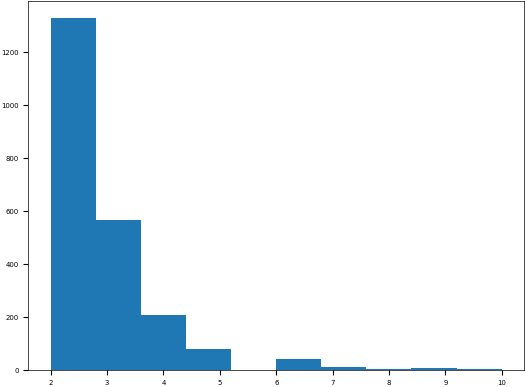

In [173]:
# Generate histogram of recurrent protein cancer counts
plt.hist(prot_data['Cancers'].tolist())

In [174]:
# Defining the top candidates as defined by the 10th position
prot_data.sort_values(by = ['Cancers', 'Fusions'], axis=0, ascending=False, inplace=True)
max_canc = prot_data.iloc[9]['Cancers']
top_prots = prot_data[prot_data['Cancers'] >= max_canc].index.tolist()
fusionOI = {k:v for k,v in recur_prots.items() if k in top_prots}
print(max_canc)

9


In [175]:
def get_protein_topology_data(prot_data, SC_topo, recur_topo,nnet):
    
    fusionOI = prot_data.copy()
    prot_arch_topo = pd.DataFrame(columns=recur_topo.columns)
    g_removal = []
    for g,dets in fusionOI.items():
        pts = dets['Patients']
        archs = dets['Domain Arch']
        pt_flag = 0
        for pt in pts:
            if pt in SC_topo.index:
                prot_arch_topo.loc[pt] = SC_topo.loc[pt]
                pt_flag = 1
            elif pt in recur_topo.index:
                prot_arch_topo.loc[pt] = recur_topo.loc[pt]
                pt_flag = 1
        
        dbl_chck = 0
        if pt_flag == 0:
            mis_arch = []
            for a in archs:
                if a not in nnet.adj.columns.tolist() and a != '':
                    mis_arch.append(a)
            if mis_arch:
                dbl_chck = 1
                #print('For gene %s no patients had their change recorded with the following missing archs:\n%s'%(g,mis_arch))    
            else:
                #print('For gene %s no patients had their change recorded but had redundant archs'%g)
                g_removal.append(g)
    
    for g in g_removal:
        del fusionOI[g]

    x = set()
    for v in fusionOI.values():
        tmp = v['Domain Arch']
        x = x.union(tmp)

    x = x.difference(nnet.adj.columns.tolist()).difference(prot_arch_topo['Domain Architecture'])

    # Finding the domain architecture and adding it back in
    for arch in x:
        if arch != '':
            if arch in SC_topo['Domain Architecture'].tolist():
                idx = SC_topo[SC_topo['Domain Architecture'] == arch].index[0]
                prot_arch_topo.loc[idx] = SC_topo.loc[idx]
            if arch in recur_topo['Domain Architecture'].tolist():
                idx = recur_topo[recur_topo['Domain Architecture'] == arch].index[0]
                prot_arch_topo.loc[idx] = recur_topo.loc[idx]

    # Making sure all domain architectures made it in
    if dbl_chck:
        mis_arch = set(mis_arch).difference(x)
        if mis_arch != set():
            print('For gene %s no patients had their change recorded with the following missing archs:\n%s'%(g,mis_arch))    

    return prot_arch_topo
            

In [176]:
prot_arch_topo = get_protein_topology_data(fusionOI, SC_topo,recur_topo, proteome_net)

In [177]:
# Printing the gene names for explanation purposes
for g in fusionOI:
    print(g)
    print(fusionOI[g]['Gene Names'])

prot_data.filter(top_prots, axis = 0)

ENSG00000185420
{'SMYD3'}
ENSG00000068078
{'FGFR3'}
ENSG00000013810
{'TACC3'}
ENSG00000141736
{'ERBB2'}
ENSG00000067900
{'ROCK1'}
ENSG00000008441
{'NFIX'}
ENSG00000196712
{'NF1'}
ENSG00000187775
{'DNAH17'}
ENSG00000062716
{'VMP1'}
ENSG00000141376
{'BCAS3'}


,Cancers,Fusions,Archs
ENSG00000196712,10,12,12
ENSG00000068078,10,4,3
ENSG00000013810,10,3,3
ENSG00000141376,9,19,12
ENSG00000062716,9,17,12
ENSG00000008441,9,14,10
ENSG00000067900,9,10,8
ENSG00000187775,9,9,7
ENSG00000185420,9,8,5
ENSG00000141736,9,5,7


In [ ]:
# Adding the results into a summary dataframe
prot_summary = pd.DataFrame(columns = ['Reinforcement','Connected Components'])

In [179]:
# Testing how it will look like if break down across cancer number
for i in range(2,11):
    top_prots = prot_data[prot_data['Cancers'] == i].index.tolist()
    fusionOI = {k:v for k,v in recur_prots.items() if k in top_prots}
    prot_arch_topo = get_protein_topology_data(fusionOI, SC_topo,recur_topo,proteome_net)
    prot_summary.loc['Multi-Cancer:'+str(i),'Reinforcement'] = sum(prot_arch_topo['Connected Components'] == 0)/len(prot_arch_topo)
    prot_summary.loc['Multi-Cancer:'+str(i),'Connected Components'] = sum(prot_arch_topo['Connected Components'] > 0)/len(prot_arch_topo)

In [180]:
# Going through the process again but with all multi-cancer proteins
fusionsOI = {k:v for k,v in recur_prots.items() if k in prot_data.index.tolist()}
prot_arch_topo = get_protein_topology_data(fusionsOI, SC_topo,recur_topo,proteome_net)

In [181]:
prot_summary.loc['Multi-Cancer','Reinforcement'] = sum(prot_arch_topo['Connected Components'] == 0)/len(prot_arch_topo)
prot_summary.loc['Multi-Cancer','Connected Components'] = sum(prot_arch_topo['Connected Components'] > 0)/len(prot_arch_topo)

In [182]:
prot_summary

,Reinforcement,Connected Components
Multi-Cancer:2,0.766193,0.233807
Multi-Cancer:3,0.756813,0.243187
Multi-Cancer:4,0.751073,0.248927
Multi-Cancer:5,0.779661,0.220339
Multi-Cancer:6,0.742424,0.257576
Multi-Cancer:7,0.692308,0.307692
Multi-Cancer:8,0.9,0.1
Multi-Cancer:9,0.5,0.5
Multi-Cancer:10,1.0,0.0
Multi-Cancer,0.754538,0.245462


In [183]:
sc_multiFus_prots = pd.DataFrame(columns=['Cancers','Fusions','Archs'])
for p in recur_prots:
    if len(recur_prots[p]['Cancers']) == 1 and len(recur_prots[p]['Fusions']) > 1:
        sc_multiFus_prots.loc[p, 'Cancers'] = len(recur_prots[p]['Cancers'])
        sc_multiFus_prots.loc[p, 'Fusions'] = len(recur_prots[p]['Fusions'])
        sc_multiFus_prots.loc[p, 'Archs'] = len(recur_prots[p]['Domain Arch'])

In [184]:
sc_multiFus_prots.sort_values('Fusions', ascending=False, inplace=True)
max_fus = sc_multiFus_prots.iloc[9]['Fusions']
top_scmf_prots = sc_multiFus_prots[sc_multiFus_prots['Fusions'] >= max_fus].index.tolist()

In [185]:
fusionOI = {k:v for k,v in recur_prots.items() if k in top_scmf_prots}
scmf_arch_topo = get_protein_topology_data(fusionOI, SC_topo,recur_topo,proteome_net)

In [187]:
fusionOI = {k:v for k,v in recur_prots.items() if k in sc_multiFus_prots.index.tolist()}
scmf_arch_topo = get_protein_topology_data(fusionOI, SC_topo,recur_topo, proteome_net)
prot_summary.loc['Single-Cancer','Reinforcement'] = sum(scmf_arch_topo['Connected Components'] == 0)/len(scmf_arch_topo)
prot_summary.loc['Single-Cancer','Connected Components'] = sum(scmf_arch_topo['Connected Components'] > 0)/len(scmf_arch_topo)

In [188]:
dbl_sc = pd.DataFrame(columns=['Cancers','Fusions','Archs'])
for p in recur_prots:
    if len(recur_prots[p]['Cancers']) == 1 and len(recur_prots[p]['Fusions']) == 1:
        dbl_sc.loc[p, 'Cancers'] = len(recur_prots[p]['Cancers'])
        dbl_sc.loc[p, 'Fusions'] = len(recur_prots[p]['Fusions'])
        dbl_sc.loc[p, 'Archs'] = len(recur_prots[p]['Domain Arch'])

In [189]:
fusionOI = {k:v for k,v in recur_prots.items() if k in dbl_sc.index.tolist()}
scmf_arch_topo = get_protein_topology_data(fusionOI, SC_topo,recur_topo,proteome_net)
prot_summary.loc['Single-Fusion','Reinforcement'] = sum(scmf_arch_topo['Connected Components'] == 0)/len(scmf_arch_topo)
prot_summary.loc['Single-Fusion','Connected Components'] = sum(scmf_arch_topo['Connected Components'] > 0)/len(scmf_arch_topo)

In [190]:
prot_summary.rename({'Single-Fusion':'Singleton'},inplace=True)

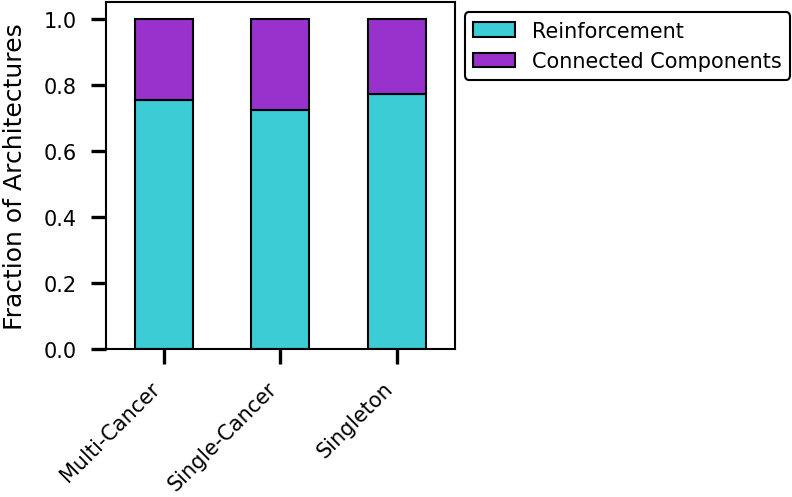

In [191]:
cols_OI = ['Multi-Cancer', 'Single-Cancer','Singleton']
prot_summary.filter(cols_OI,axis=0).plot.bar(stacked=True,figsize=(1.5,1.5),edgecolor='k',linewidth = 0.5,color=['#3bccd6','#9932cc'])
plt.ylabel('Fraction of Architectures', fontdict={'size':6})
plt.gcf().set_dpi(300)
l= plt.legend(loc = 'best', bbox_to_anchor = (1,1),fontsize = 5)
l.get_frame().set_alpha(1)
l.get_frame().set_linewidth(0.5)
l.get_frame().set_edgecolor('k')
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='both', labelsize = 5)
plt.savefig('Figures/Manuscript Figures/Figure 3 Fusion Genes/Fusion Gene Recurrence Pan Cancer Gross Topology.svg', transparent = True)

In [192]:
prot_summary.filter(cols_OI,axis=0)

,Reinforcement,Connected Components
Multi-Cancer,0.754538,0.245462
Single-Cancer,0.723214,0.276786
Singleton,0.770932,0.229068
